In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [48]:
# --- STEP 1: LOAD REAL DATASET ---
# Loading the dataset directly from a stable GitHub source
dataset_url = "https://raw.githubusercontent.com/richardcsuwandi/airline-sentiment/master/tweets.csv"
print(f"Downloading dataset from: {dataset_url}...")
df = pd.read_csv(dataset_url)

In [49]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,latitude,longitude
0,5.703061e+17,neutral,1.0000,NaN,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800,35.888455,-119.273781
1,5.703011e+17,positive,0.3486,NaN,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800,37.770971,-119.941025
2,5.703011e+17,neutral,0.6837,NaN,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48 -0800,35.684863,-119.709299
3,5.703010e+17,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800,37.061159,-119.279135
4,5.703008e+17,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800,36.790587,-120.867752


In [50]:
df=df[['text','airline_sentiment']]

In [51]:
df.shape

(14640, 2)

In [52]:
df.head(3)

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral


In [53]:
# --- STEP 2: PREPROCESSING ---
# Convert sentiment to numbers (Negative=0, Neutral=1, Positive=2)
le=LabelEncoder()

In [54]:
df['sentiment_encoded']=le.fit_transform(df['airline_sentiment'])

In [55]:
df.tail(5)

,text,airline_sentiment,sentiment_encoded
14635,@AmericanAir thank you we got on a different f...,positive,2
14636,@AmericanAir leaving over 20 minutes Late Flig...,negative,0
14637,@AmericanAir Please bring American Airlines to...,neutral,1
14638,"@AmericanAir you have my money, you change my ...",negative,0
14639,@AmericanAir we have 8 ppl so we need 2 know h...,neutral,1


In [56]:
#Tokenization: converting text words into numbers
vocab_size=5000
max_length=50
padding_type='post'
trunc_type='post'
oov_tok="<OOV>" #for out of vocabulary words
embedding_dim = 64

tokenizer=Tokenizer(num_words=vocab_size,oov_token=oov_tok)
tokenizer.fit_on_texts(df['text'])
sequences=tokenizer.texts_to_sequences(df['text'])
padded=pad_sequences(sequences,maxlen=max_length,truncating=trunc_type)

In [57]:
# Split into Training and Test sets
X_train, X_test, y_train, y_test = train_test_split(padded, df['sentiment_encoded'], test_size=0.2, random_state=42)

In [58]:
# --- STEP 3: BUILD DEEP LEARNING MODEL (Bi-LSTM) ---
model = Sequential([
    # ADD input_length=max_length HERE
    Embedding(vocab_size, 64, input_length=max_length),

    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

# Now build the model explicitly by passing a sample input shape
# (batch_size, sequence_length) -> (None, 50)
model.build(input_shape=(None, max_length))

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ (None, 50, 64)         │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_18                │ (None, 50, 128)        │        66,048 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_19                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 431,619 (1.65 MB)

 Trainable params: 431,619 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

In [59]:
# 4. COMPILE & TRAIN
print("\nCompiling and Training Model...")

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)


Compiling and Training Model...
Epoch 1/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 38s 87ms/step - accuracy: 0.6589 - loss: 0.7946 - val_accuracy: 0.7476 - val_loss: 0.6008
Epoch 2/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 41s 86ms/step - accuracy: 0.8073 - loss: 0.4995 - val_accuracy: 0.8050 - val_loss: 0.5089
Epoch 3/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 39s 81ms/step - accuracy: 0.8733 - loss: 0.3465 - val_accuracy: 0.8036 - val_loss: 0.5209
Epoch 4/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 31s 84ms/step - accuracy: 0.9117 - loss: 0.2646 - val_accuracy: 0.7978 - val_loss: 0.5852
Epoch 5/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 30s 83ms/step - accuracy: 0.9355 - loss: 0.1961 - val_accuracy: 0.7913 - val_loss: 0.6851
Epoch 6/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 44s 90ms/step - accuracy: 0.9455 - loss: 0.1587 - val_accuracy: 0.7766 - val_loss: 0.7438
Epoch 7/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 38s 83ms/step - accuracy: 0.9595 - loss: 0.1307 - val_accuracy: 0.7719 - val_loss: 0.7455
Epoch 8/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 32s 86ms/step - a


Plotting Results...


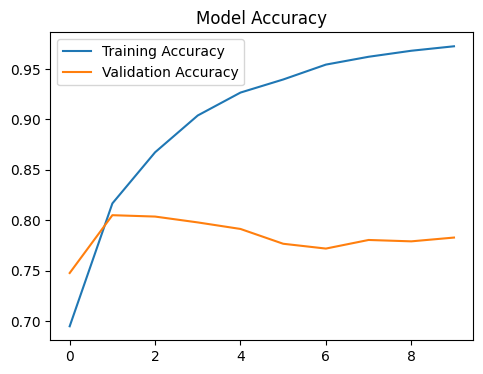

In [60]:
# 5. VISUALIZATION
print("\nPlotting Results...")

# Plot Accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.legend()

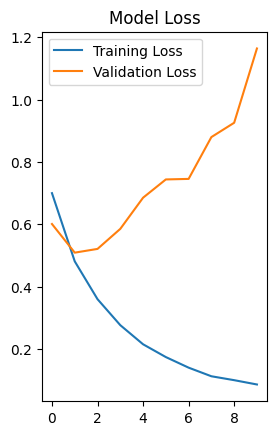

In [61]:
# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

In [62]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# ==========================================
# 3. BUILD THE ROBUST MODEL (FIXED)
# ==========================================
print("\nBuilding Robust Model...")

model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),

    # ADDED: L2 Regularization and decreased units to 32
    # This forces the model to learn simpler patterns that generalize better
    Bidirectional(LSTM(32, return_sequences=True, kernel_regularizer=l2(0.01))),
    Dropout(0.4), # Increased Dropout to 40%

    Bidirectional(LSTM(16, kernel_regularizer=l2(0.01))),
    Dropout(0.4),

    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(3, activation='softmax')
])

model.build(input_shape=(None, max_length))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

# ==========================================
# 4. TRAIN WITH EARLY STOPPING
# ==========================================
print("\nTraining with Early Stopping...")

# STOPPING RULE: "If val_loss doesn't go down for 3 epochs, STOP."
# restore_best_weights=True ensures we go back to the best version (Epoch 1 or 2)
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train,
    y_train,
    epochs=20,          # Set this high; EarlyStopping will cut it short automatically
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop], # <--- Critical addition
    verbose=1
)


Building Robust Model...


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ (None, 50, 64)         │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_20                │ (None, 50, 64)         │        24,832 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_21                │ (None, 32)             │        10,368 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,355 (1.36 MB)

 Trainable params: 356,355 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

None

Training with Early Stopping...
Epoch 1/20
366/366 ━━━━━━━━━━━━━━━━━━━━ 29s 62ms/step - accuracy: 0.6436 - loss: 2.2183 - val_accuracy: 0.7281 - val_loss: 0.6927
Epoch 2/20
366/366 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - accuracy: 0.7569 - loss: 0.6273 - val_accuracy: 0.7643 - val_loss: 0.6221
Epoch 3/20
366/366 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.7901 - loss: 0.5419 - val_accuracy: 0.7439 - val_loss: 0.6327
Epoch 4/20
366/366 ━━━━━━━━━━━━━━━━━━━━ 39s 59ms/step - accuracy: 0.8087 - loss: 0.4869 - val_accuracy: 0.7582 - val_loss: 0.6828
Epoch 5/20
366/366 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - accuracy: 0.8423 - loss: 0.4367 - val_accuracy: 0.7596 - val_loss: 0.7273


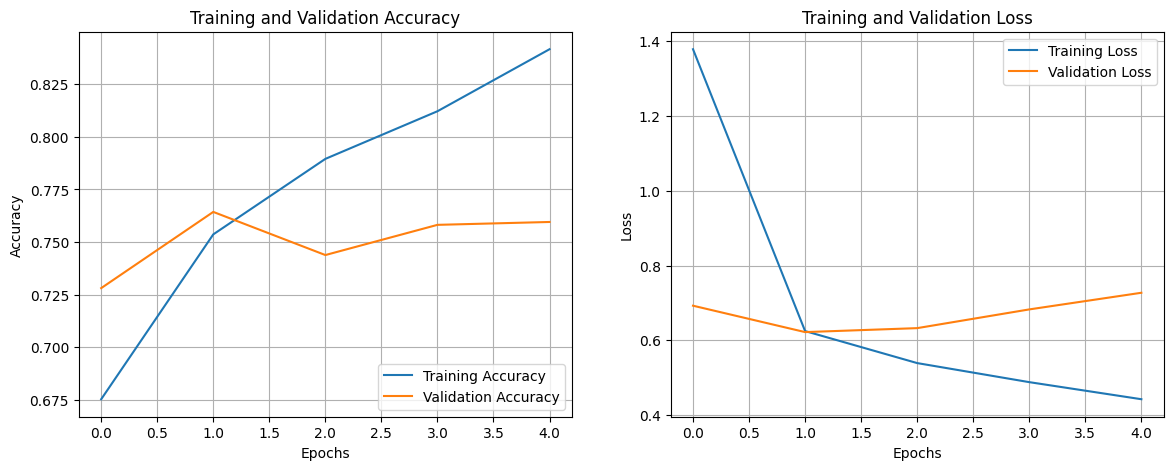

In [63]:
import matplotlib.pyplot as plt

# Retrieve the data from the training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a range for the x-axis (epochs)
epochs_range = range(len(acc))

# Plotting Accuracy and Loss side-by-side
plt.figure(figsize=(14, 5))

# Graph 1: Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True) # Added grid for easier reading

# Graph 2: Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.show()

In [64]:
# Function to test manually (ensure this is defined)
def predict_sentiment(text):
    new_seq = tokenizer.texts_to_sequences([text])
    new_padded = pad_sequences(new_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
    prediction = model.predict(new_padded)
    class_id = np.argmax(prediction)
    return le.inverse_transform([class_id])[0]

# TEST CASES
reviews = [
    "The flight was on time and the staff was polite.",   # Obvious Positive
    "I waited for 3 hours and lost my luggage.",          # Obvious Negative
    "The food was okay, but the seat was uncomfortable.", # Mixed/Negative (Hard)
    "I don't hate the service, it was actually decent."   # Double Negative (Tricky)
]

print("\n--- REAL WORLD TESTING ---")
for review in reviews:
    print(f"Review: '{review}'")
    print(f"Prediction: {predict_sentiment(review)}\n")


--- REAL WORLD TESTING ---
Review: 'The flight was on time and the staff was polite.'
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step
Prediction: neutral

Review: 'I waited for 3 hours and lost my luggage.'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Prediction: negative

Review: 'The food was okay, but the seat was uncomfortable.'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Prediction: positive

Review: 'I don't hate the service, it was actually decent.'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Prediction: neutral

